# 7-ParallelEfficiency
This notebook evaluates the scaling of Dask, Spark, and DaskCuda dataframe libraries with respect to the number of cores and the file format of the data file ([csv](https://en.wikipedia.org/wiki/Comma-separated_values). vs. [parquet](https://parquet.apache.org/)). The executed notebooks with output and plots are saved in the [results directory](results). Note: this is not a representative comparison of these dataframe libraries.

See Robert Sinkovits' [Parallel Computing Concepts](https://github.com/sdsc/sdsc-summer-institute-2022/tree/main/2.1_parallel_computing_concepts) for details.

Author: Peter W. Rose (pwrose@ucsd.edu)

In [1]:
import os
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import papermill as pm

In [2]:
%matplotlib inline

If LOCAL_SCRATCH_DIR environment variable is not set, this notebook accesses the ../data directory for temporary files.

In [3]:
DATA_DIR = os.getenv("LOCAL_SCRATCH_DIR", default="../data")
filename = os.path.join(DATA_DIR, "gene_info.tsv")
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
print(f"Filename: {filename}")
file_size = os.path.getsize(filename)
print(f"File Size: {file_size/1E9:.1f} GB")
print(f"Benchmark results directory: {RESULTS_DIR}")

Filename: ../data/gene_info.tsv
File Size: 5.4 GB
Benchmark results directory: results


### Setup Benchmark

#### Specify the number of cores to be used for benchmarking.

In [5]:
cores = [1, 2, 4, 6, 8, 10]

In [6]:
style = {'description_width': "initial"}
f_widget = widgets.RadioButtons(options=["csv", "parquet"], description="Select input file format:", value="csv", style=style)
d_widget = widgets.RadioButtons(options=["Dask", "Spark", "DaskCuda (GPU)"], description="Select dataframe library:", value="Dask", style=style)

#### Select input format and dataframe library

In [8]:
display(f_widget, d_widget)

RadioButtons(description='Select input file format:', options=('csv', 'parquet'), style=DescriptionStyle(descr…

RadioButtons(description='Select dataframe library:', index=1, options=('Dask', 'Spark', 'DaskCuda (GPU)'), st…

In [9]:
file_format = f_widget.value
dataframe = d_widget.value
df_libraries = {"Dask": "3-DaskDataframe.ipynb", "Spark": "4-SparkDataframe.ipynb", "DaskCuda (GPU)": "6-DaskCudaDataframe"}
notebook = df_libraries.get(dataframe)

In [10]:
print(f"File format: {file_format}")
print(f"Dataframe  : {dataframe}")
print(f"Notebook   : {notebook}")

File format: csv
Dataframe  : Spark
Notebook   : 4-SparkDataframe.ipynb


### Run Benchmark
This benchmark runs Jupyter Notebooks with two input parameters: the number of cores and the file format of the input file. It uses [papermill](https://papermill.readthedocs.io/en/latest/) to execute the notebooks non-interactively. The executed notebooks with output and plots are saved in the [results directory](results).

In [11]:
timing = []
for n_cores in cores:
    start = time.time()
    
    name, _ = os.path.splitext(notebook)
    notebook_out = os.path.join(RESULTS_DIR, f"{name}_{file_format}_{n_cores}.ipynb")
    
    pm.execute_notebook(notebook, notebook_out, parameters={"n_cores": n_cores, "file_format": file_format})
       
    end = time.time()
    
    print(f"cores: {n_cores} time: {end-start:.1f} s")
    timing.append({"cores": n_cores, "time": end-start})

Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/29 01:21:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


cores: 1 time: 98.3 s


Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/29 01:23:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


cores: 2 time: 61.3 s


Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/29 01:24:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


cores: 4 time: 42.5 s


Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/29 01:25:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


cores: 6 time: 45.3 s


Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/29 01:25:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


cores: 8 time: 47.9 s


In [12]:
df = pd.DataFrame(timing)
df["efficiency"] = df["time"].iloc[0] / (df["time"] * df["cores"])
df

,cores,time,efficiency
0,1,98.295683,1.000000
1,2,61.287706,0.801920
2,4,42.481817,0.578457
3,6,45.259153,0.361973
4,8,47.946745,0.256263


### Plot Runtime as Function of Cores

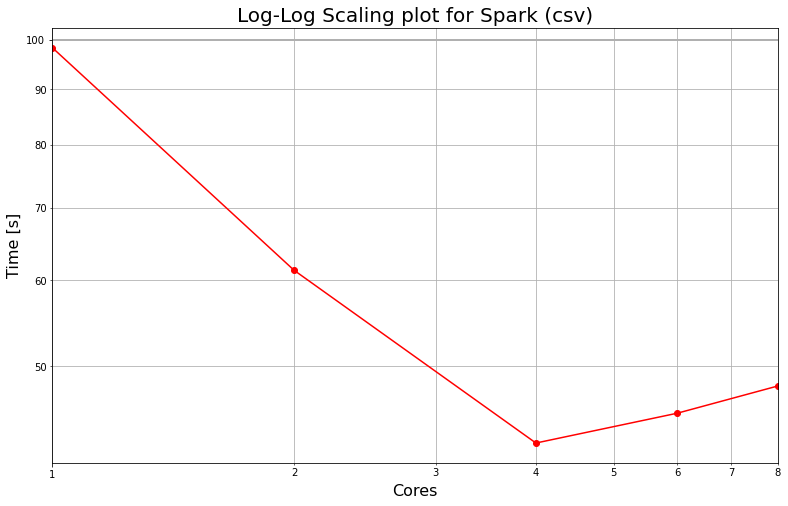

In [13]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.loglog()
for axis in [ax.xaxis, ax.yaxis]:
    formatter = matplotlib.ticker.FormatStrFormatter("%d")
    axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)
ax.grid(visible=True, which='major', linewidth=2)
ax.grid(visible=True, which='minor')
plt.title(f"Log-Log Scaling plot for {dataframe} ({file_format})", fontsize=20)
plt.xlabel("Cores", fontsize=16)
plt.ylabel("Time [s]", fontsize=16)
plt.xlim([1, n_cores])
plt.plot(df["cores"].values, df["time"].values, 'ro-')

plt.savefig(os.path.join("results",f"{dataframe}_scaling.png"), dpi=300)
plt.show()

### Plot Parallel Efficiency as Function of Cores

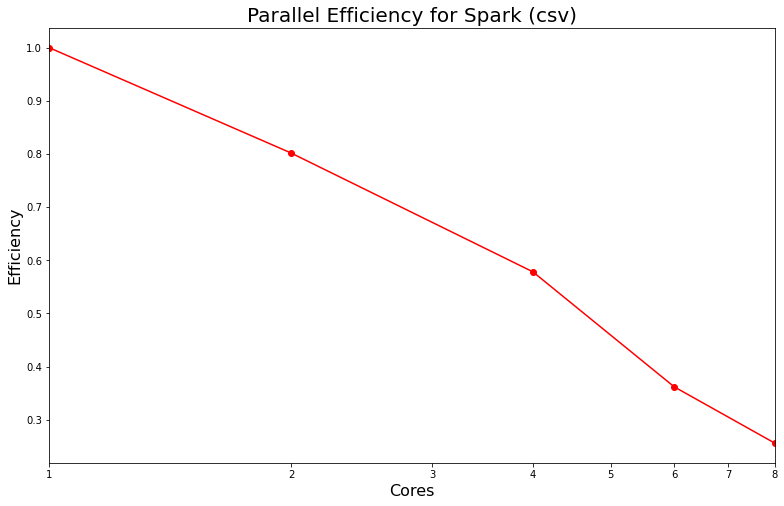

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_xscale('log')
formatter = matplotlib.ticker.FormatStrFormatter("%d")
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(formatter)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
                                                         
plt.title(f"Parallel Efficiency for {dataframe} ({file_format})", fontsize=20)
plt.xlabel("Cores", fontsize=16)
plt.ylabel("Efficiency", fontsize=16)
plt.xlim([1, n_cores])
plt.plot(df["cores"].values, df["efficiency"].values, 'ro-')

plt.savefig(os.path.join("results", f"{dataframe}_efficiency.png"), dpi=300)
plt.show()